# Ordinal Regression of Outcomes Categorical variable

This scenario includes another response variable: time in offensive/neutral/headon/defensive state

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.nn import Module as TModule
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

import itertools
import collections
from adjustText import adjust_text

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.metrics import scotts_pi

Data transform and EDA

In [298]:
class UniformPrior(gpytorch.priors.Prior, torch.distributions.Uniform):
  """
  Uniform prior
  """

  def __init__(self, low, high, validate_args=None, transform=None):
    if not isinstance(low, torch.Tensor):
      low = torch.tensor(low, dtype=torch.float)
    if not isinstance(high, torch.Tensor):
      high = torch.tensor(high, dtype=torch.float)
    TModule.__init__(self)
    self.low = low
    self.high = high
    torch.distributions.Uniform.__init__(self, low, high, validate_args=validate_args)
    del self.low
    del self.high
    self.register_buffer("low", low)
    self.register_buffer("high", high)
    # gpytorch.priors.utils._bufferize_attributes("alpha0", ("alpha0"))
    # gpytorch.priors.utils._bufferize_attributes("beta0", ("beta0"))
    self._transform = transform 

  def expand(self, batch_shape):
    batch_shape = torch.Size(batch_shape)
    return UniformPrior(self.low.expand(batch_shape), self.high.expand(batch_shape))

In [73]:
class BetaPrior(gpytorch.priors.Prior, torch.distributions.Beta):
  """
  Beta prior
  """

  def __init__(self, alpha0, beta0, validate_args=None, transform=None):
    if not isinstance(alpha0, torch.Tensor):
      alpha0 = torch.tensor(alpha0)
    if not isinstance(beta0, torch.Tensor):
      beta0 = torch.tensor(beta0)
    TModule.__init__(self)
    self.alpha0 = alpha0
    self.beta0 = beta0
    torch.distributions.Beta.__init__(self, alpha0, beta0, validate_args=validate_args)
    del self.alpha0
    del self.beta0
    self.register_buffer("alpha0", alpha0)
    self.register_buffer("beta0", beta0)
    # gpytorch.priors.utils._bufferize_attributes("alpha0", ("alpha0"))
    # gpytorch.priors.utils._bufferize_attributes("beta0", ("beta0"))
    self._transform = transform 

  def expand(self, batch_shape):
    batch_shape = torch.Size(batch_shape)
    return BetaPrior(self.alpha0.expand(batch_shape), self.beta0.expand(batch_shape))

In [74]:
df1 = pd.read_csv("../ace0/msl_evasion-004/msl_evasion-case-v4.1.csv")
df2 = pd.read_csv("../ace0/msl_evasion-004/msl_evasion-case-v4.2.csv")
df2.run_number = df2.run_number + 1000
# df = pd.concat([df1, df2])
df = df1
# df = df2
df.reset_index(drop=True)
df = df.reset_index(drop=True)

<AxesSubplot: ylabel='Density'>

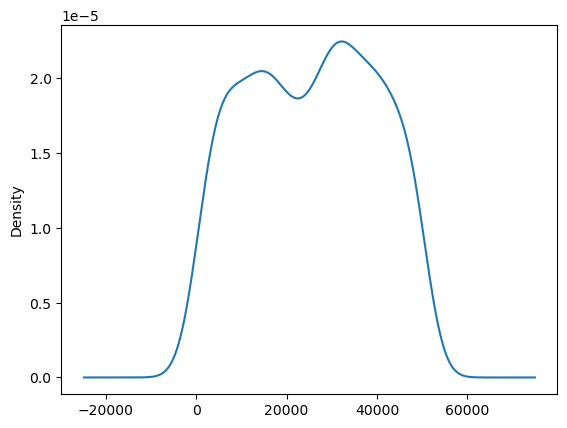

In [75]:
df.cobra_briefed_evasion_range.plot(kind="density")

In [76]:
df[df.viper_time_in_UNKNOWN > .3]

,run_number,total_run_time,viper_initial_contact_range,viper_initial_contact_ata,viper_initial_contact_aa,viper_briefed_behavior,viper_briefed_launch_range,viper_briefed_evasion_range,viper_alive,cobra_initial_contact_range,...,viper_time_in_UNKNOWN,cobra_time_in_UNKNOWN,viper_time_in_NEUTRAL,cobra_time_in_NEUTRAL,viper_time_in_DEFENSIVE,cobra_time_in_DEFENSIVE,viper_time_in_HEADON,cobra_time_in_HEADON,viper_time_in_OFFENSIVE,cobra_time_in_OFFENSIVE
25,26,300.0,50000.0,0.000,180.000,BehaviorType.ATTACK,49430.973522,25723.782667,1,50000.0,...,242.1,0.2,0.0,0.0,0.0,0.0,58.0,57.9,0.0,0.0
99,100,300.0,50000.0,-0.000,-180.000,BehaviorType.ATTACK,49954.070253,25769.158682,1,50000.0,...,242.5,0.2,0.0,0.0,0.0,0.0,57.6,57.5,0.0,0.0
101,102,300.0,50000.0,-0.001,-179.999,BehaviorType.ATTACK,49699.082322,26606.363426,1,50000.0,...,242.2,0.2,0.0,0.0,0.0,0.0,57.9,57.8,0.0,0.0
121,122,300.0,50000.0,-0.001,-179.999,BehaviorType.ATTACK,49947.230357,26034.008768,1,50000.0,...,242.6,0.2,0.0,0.0,0.0,0.0,57.5,57.4,0.0,0.0
131,132,300.0,50000.0,0.001,179.999,BehaviorType.ATTACK,49756.689254,26367.605334,1,50000.0,...,242.3,0.2,0.0,0.0,0.0,0.0,57.8,57.7,0.0,0.0
461,462,300.0,50000.0,-0.002,-179.998,BehaviorType.ATTACK,49535.319395,26653.558935,1,50000.0,...,241.6,0.2,0.0,0.0,0.0,0.3,58.1,58.1,0.4,0.0
847,848,300.0,50000.0,-0.002,-179.998,BehaviorType.ATTACK,49693.935898,26102.574332,1,50000.0,...,242.4,0.2,0.0,0.0,0.0,0.0,57.7,57.6,0.0,0.0


In [77]:
idx_high_unknown = df[(df.viper_time_in_UNKNOWN > 0.2) | (df.cobra_time_in_UNKNOWN > 0.2)].index
print("highest time in UNKNOWN: ", df.iloc[idx_high_unknown].total_run_time.max())

highest time in UNKNOWN:  300.0


In [78]:
# q = .7
# viper_evansion_quantile = df.viper_briefed_evasion_range.quantile(.77)
# cobra_evansion_quantile = df.cobra_briefed_evasion_range.quantile(.77)

# idx = (df.viper_briefed_evasion_range < viper_evansion_quantile) & (df.cobra_briefed_evasion_range < cobra_evansion_quantile)

# df = df[idx]
# df.reset_index(drop=True, inplace=True)

In [79]:
idx_high_unknown = df[(df.viper_time_in_UNKNOWN > 0.2) | (df.cobra_time_in_UNKNOWN > 0.2)].index
print("highest time in UNKNOWN: ", df.iloc[idx_high_unknown].total_run_time.max())

highest time in UNKNOWN:  300.0


<AxesSubplot: ylabel='Density'>

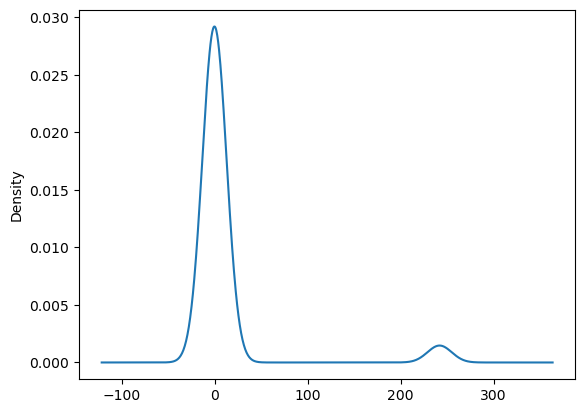

In [80]:
df_timein = df.iloc[:,df.columns.str.contains("viper_time_in") | df.columns.str.contains("total_run")]
df_timein["viper_total_run_time"] = df_timein.iloc[:,1:].sum(axis=1)
(df_timein.total_run_time - df_timein.viper_total_run_time).plot(kind="density")

In [81]:
subset_idx = list(set(df.index) - set(idx_high_unknown))
df = df.iloc[subset_idx]
df = df.reset_index(drop=True)

In [82]:
df.viper_time_in_HEADON = df.viper_time_in_HEADON + df.viper_time_in_UNKNOWN
df.cobra_time_in_HEADON = df.cobra_time_in_HEADON + df.cobra_time_in_UNKNOWN

In [83]:
unknown_col = df.iloc[:,df.columns.str.contains("time_in_UNKNOWN")].columns
df = df.drop(unknown_col, axis=1)

In [84]:
# viper_timein_col = [col for col in df.columns if "total_run" in col or "viper_time_in" in col]
# cobra_timein_col = [col for col in df.columns if "total_run" in col or "cobra_time_in" in col]

viper_timein_col = [col for col in df.columns if "viper_time_in" in col]
cobra_timein_col = [col for col in df.columns if "cobra_time_in" in col]

df_viper_portion = df[viper_timein_col].apply(lambda x: x / df.total_run_time)
df_cobra_portion = df[cobra_timein_col].apply(lambda x: x / df.total_run_time)

In [85]:
viper_portion_cols = [
    'viper_p_NEUTRAL', 
    'viper_p_DEFENSIVE',
    'viper_p_HEADON', 
    'viper_p_OFFENSIVE'
]

cobra_portion_cols = [
    'cobra_p_NEUTRAL', 
    'cobra_p_DEFENSIVE',
    'cobra_p_HEADON', 
    'cobra_p_OFFENSIVE'
]

df_viper_portion.columns = viper_portion_cols
df_cobra_portion.columns = cobra_portion_cols

In [86]:
df_viper_portion.max(), df_cobra_portion.max()

(viper_p_NEUTRAL      0.787252
 viper_p_DEFENSIVE    0.792422
 viper_p_HEADON       1.001736
 viper_p_OFFENSIVE    0.792593
 dtype: float64,
 cobra_p_NEUTRAL      0.787252
 cobra_p_DEFENSIVE    0.792593
 cobra_p_HEADON       1.001736
 cobra_p_OFFENSIVE    0.792422
 dtype: float64)

In [87]:
df_viper_portion.viper_p_HEADON = df_viper_portion.viper_p_HEADON.apply(lambda x: min(x, 1.0))
df_cobra_portion.cobra_p_HEADON = df_cobra_portion.cobra_p_HEADON.apply(lambda x: min(x, 1.0))

In [88]:
df = pd.concat([df, df_viper_portion, df_cobra_portion], axis=1)
df = df.reset_index(drop=True)

In [89]:
df.outcome.value_counts()

BOTH_SURVIVED    503
COBRA_WIN        230
VIPER_WIN        212
MUTUAL_KILL       42
Name: outcome, dtype: int64

In [90]:
# We remove MUTUAL_KILL and keep the variables ordered as:
# VIPER_WIN = 2
# BOTH_SURVIVED = 1
# COBRA_WIN = 0

outcome_map = {
    "VIPER_WIN": 2,
    "BOTH_SURVIVED": 1,
    "COBRA_WIN": 0,
}

df = df[df.outcome != "MUTUAL_KILL"]
df.outcome = df.outcome.map(outcome_map)

# outcome_map = {
#     "VIPER_WIN": 3,
#     "BOTH_SURVIVED": 2,
#     "MUTUAL_KILL": 1,
#     "COBRA_WIN": 0,
# }
# df.outcome = df.outcome.map(outcome_map)

log_standardise = lambda x: (np.log(x) - np.mean(np.log(x))) / np.std(np.log(x))
log_norm = lambda x: (np.log(x) - np.min(np.log(x))) / (np.max(np.log(x)) - np.min(np.log(x)))
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def norm_custom(x, minval, maxval):
    x = (x - minval) / (maxval - minval)
    return x

# log normalise data
df["lognorm_viper_launch_range"] = df.viper_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(log_norm)
df["lognorm_cobra_launch_range"] = df.cobra_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(log_norm)

# normalise data
df["norm_viper_launch_range"] = df.viper_launch_range.pipe(norm)
df["norm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(norm)
df["norm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(norm)
df["norm_cobra_launch_range"] = df.cobra_launch_range.pipe(norm)
df["norm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(norm)
df["norm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(norm)

# compute min, max vals among both cobra and viper
evasion_minval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).min()
evasion_maxval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).max()
launch_minval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).min()
launch_maxval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).max()
briefed_launch_minval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).min()
briefed_launch_maxval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).max()

# difference between evasion and launch. normalised
df["briefed_evasion_range_diff"] = df.viper_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval)) - df.cobra_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval))
df["launch_range_diff"] = df.viper_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval)) - df.cobra_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval))
df["briefed_launch_range_diff"] = df.viper_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval)) - df.cobra_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval))

# difference between time launched
df["time_at_launch_diff"] = df.viper_time_at_launch - df.cobra_time_at_launch

<AxesSubplot: xlabel='viper_briefed_launch_range', ylabel='viper_launch_range'>

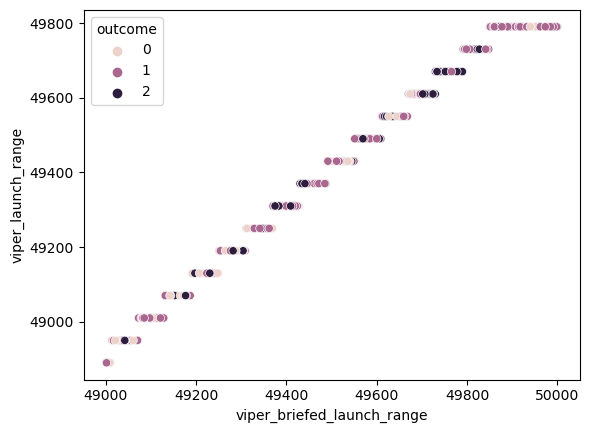

In [91]:
# when viper launches first, viper typically has a longer briefed launch range
sns.scatterplot(x=df.viper_briefed_launch_range, y=df.viper_launch_range, hue=df.outcome)

<AxesSubplot: xlabel='time_at_launch_diff', ylabel='briefed_launch_range_diff'>

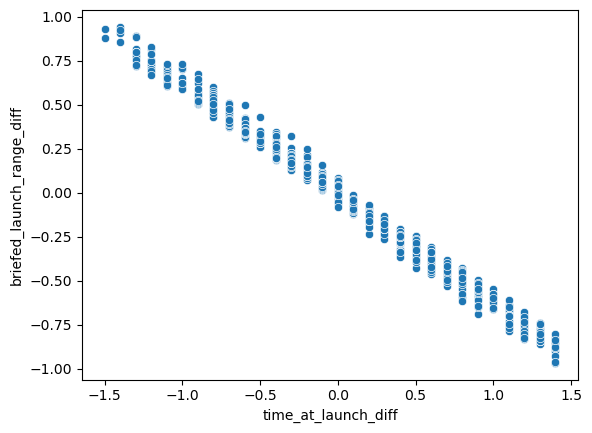

In [92]:
# when viper launches first, viper typically has a longer briefed launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.briefed_launch_range_diff)

<AxesSubplot: xlabel='time_at_launch_diff', ylabel='launch_range_diff'>

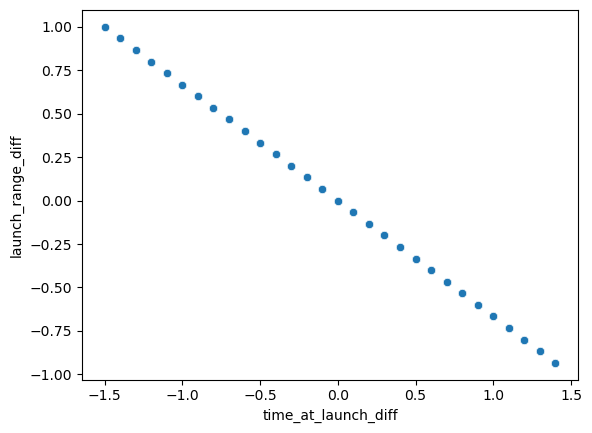

In [93]:
# when viper launches first, viper has a longer launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.launch_range_diff)

<AxesSubplot: xlabel='time_at_launch_diff', ylabel='launch_range_diff'>

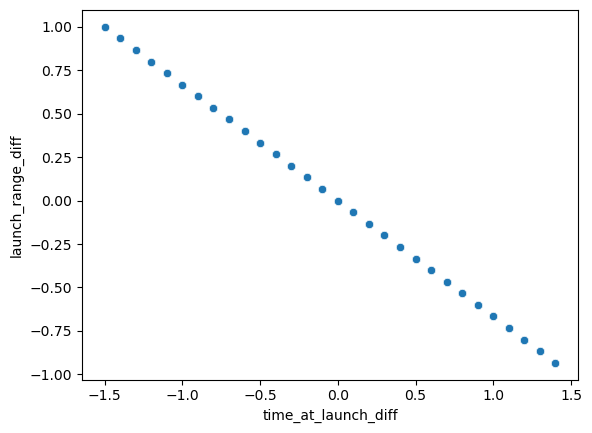

In [94]:
# when viper launches first, viper has a longer launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.launch_range_diff)

<AxesSubplot: xlabel='time_at_launch_diff', ylabel='Density'>

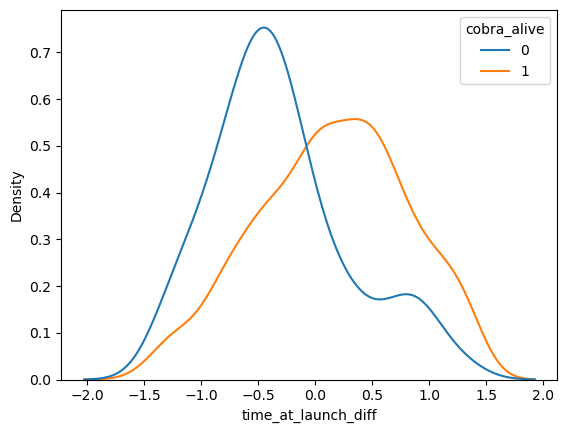

In [95]:
sns.kdeplot(x=df.time_at_launch_diff, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='briefed_evasion_range_diff', ylabel='launch_range_diff'>

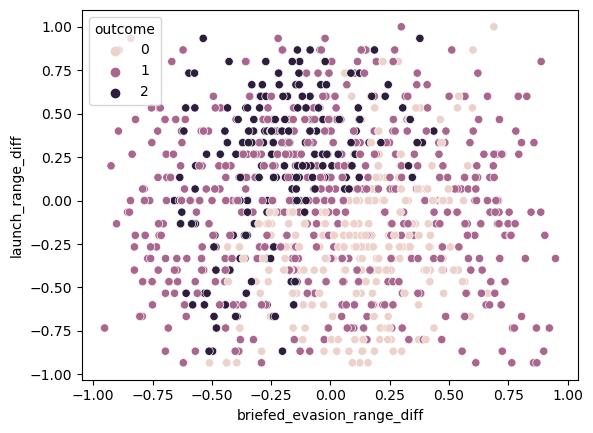

In [96]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(x=df.briefed_evasion_range_diff, y=df.launch_range_diff, hue=df.outcome)

In [27]:
df.head()

,run_number,total_run_time,viper_initial_contact_range,viper_initial_contact_ata,viper_initial_contact_aa,viper_briefed_behavior,viper_briefed_launch_range,viper_briefed_evasion_range,viper_alive,cobra_initial_contact_range,...,norm_viper_launch_range,norm_viper_briefed_launch_range,norm_viper_briefed_evasion_range,norm_cobra_launch_range,norm_cobra_briefed_launch_range,norm_cobra_briefed_evasion_range,briefed_evasion_range_diff,launch_range_diff,briefed_launch_range_diff,time_at_launch_diff
0,1,58.0,50000.0,0.001,179.999,BehaviorType.ATTACK,49722.591590,19348.381068,1,50000.0,...,0.996385,0.990758,0.495734,0.995180,0.988084,0.248566,0.250312,0.001205,0.002799,-0.1
1,2,120.7,50000.0,0.000,180.000,BehaviorType.ATTACK,49799.981986,29676.651785,1,50000.0,...,0.998795,0.993338,0.760623,0.990360,0.979914,0.994961,-0.219352,0.008435,0.013518,-0.7
2,3,59.8,50000.0,-0.000,-180.000,BehaviorType.ATTACK,49127.543781,6778.721982,1,50000.0,...,0.984335,0.970918,0.173361,0.996385,0.989299,0.814087,-0.628610,-0.012050,-0.018252,1.0
3,4,57.7,50000.0,0.001,179.999,BehaviorType.ATTACK,49031.428209,24996.442932,0,50000.0,...,0.983129,0.967713,0.640589,0.998795,0.994665,0.408059,0.238205,-0.015665,-0.026802,1.3
4,5,57.9,50000.0,0.000,180.000,BehaviorType.ATTACK,49681.213269,5988.939926,1,50000.0,...,0.996385,0.989378,0.153105,0.991565,0.981482,0.338199,-0.180528,0.004820,0.007996,-0.4


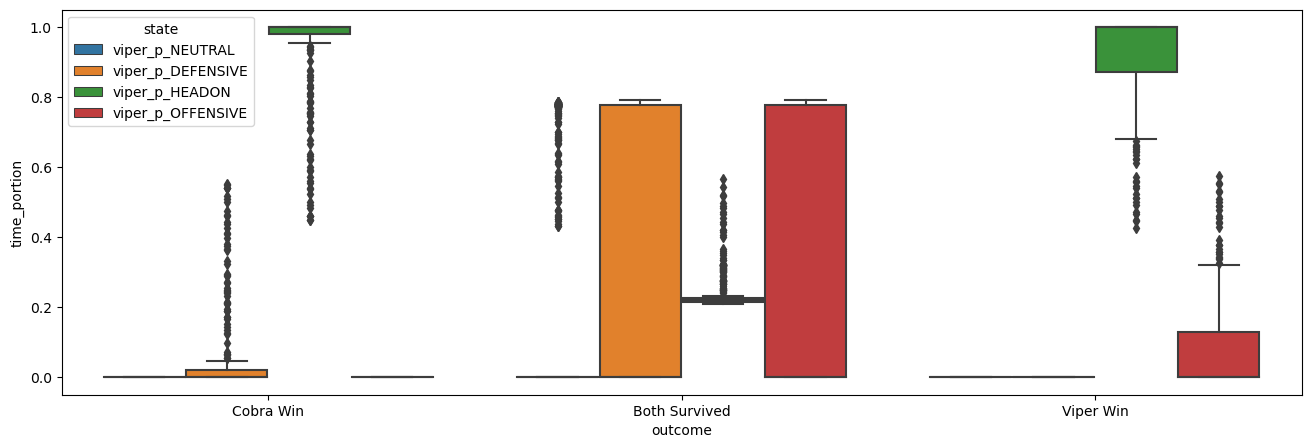

In [98]:
plt.figure(figsize=(16,5))
df_box = df.melt(id_vars=["run_number", "outcome"], value_vars=viper_portion_cols, value_name="time_portion", var_name="state")
sns.boxplot(data=df_box, x="outcome", y="time_portion", hue="state")
# plt.xticks([0, 1, 2, 3], labels=["Cobra Win", "Mutual Kill", "Both Survived", "Viper Win"]);
plt.xticks([0, 1, 2], labels=["Cobra Win", "Both Survived", "Viper Win"]);

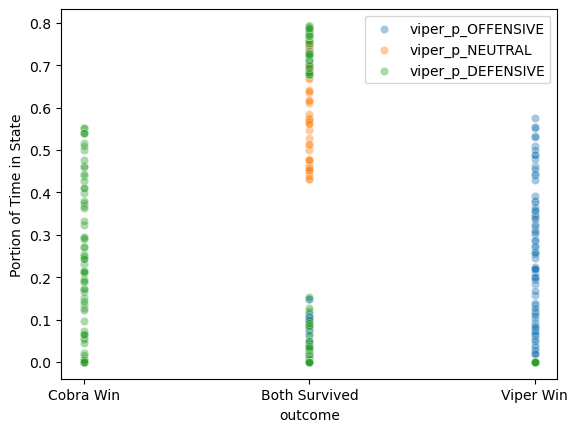

In [99]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(y=df.viper_p_OFFENSIVE , x=df.outcome, alpha=.4, label="viper_p_OFFENSIVE")
sns.scatterplot(y=df.viper_p_NEUTRAL , x=df.outcome, alpha=.4, label="viper_p_NEUTRAL")
sns.scatterplot(y=df.viper_p_DEFENSIVE , x=df.outcome, alpha=.4, label="viper_p_DEFENSIVE")
plt.ylabel("Portion of Time in State")
# plt.xticks([0, 1, 2, 3], labels=["Cobra Win", "Mutual Kill", "Both Survived", "Viper Win"]);
plt.xticks([0, 1, 2], labels=["Cobra Win", "Both Survived", "Viper Win"]);

<AxesSubplot: xlabel='viper_time_at_launch', ylabel='Density'>

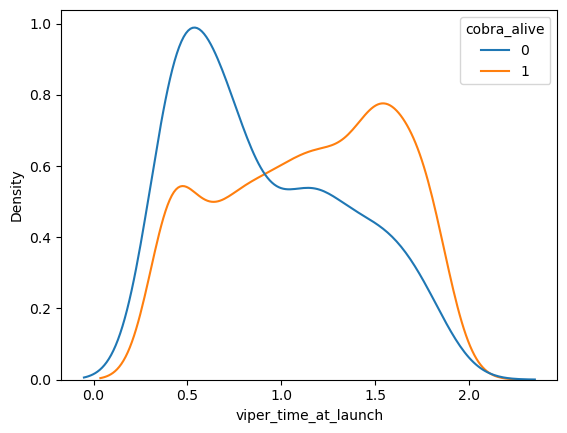

In [100]:
sns.kdeplot(x=df.viper_time_at_launch, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='cobra_time_at_launch', ylabel='Density'>

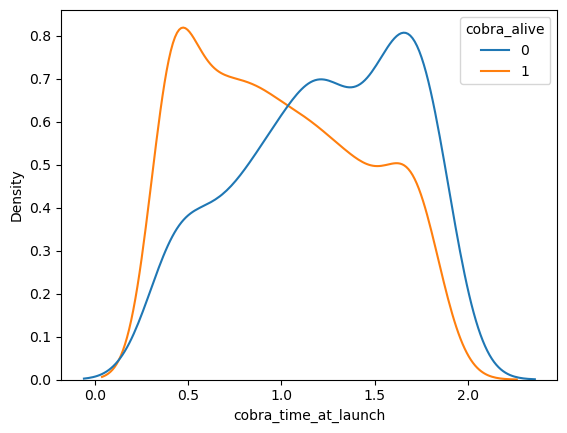

In [101]:
sns.kdeplot(x=df.cobra_time_at_launch, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_viper_launch_range', ylabel='Density'>

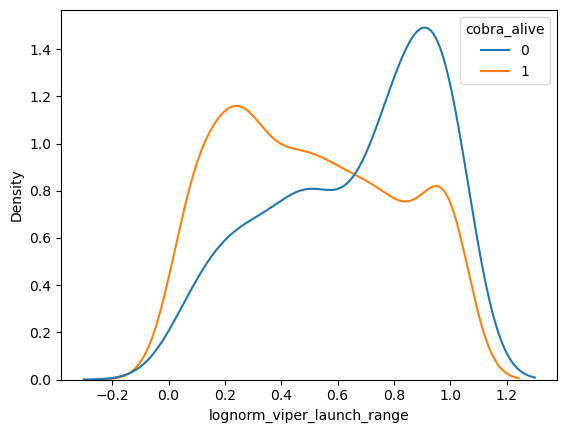

In [102]:
sns.kdeplot(x=df.lognorm_viper_launch_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_cobra_launch_range', ylabel='Density'>

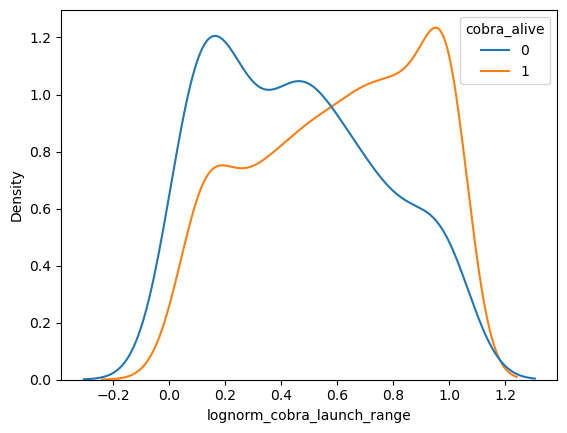

In [103]:
sns.kdeplot(x=df.lognorm_cobra_launch_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_viper_briefed_evasion_range', ylabel='Density'>

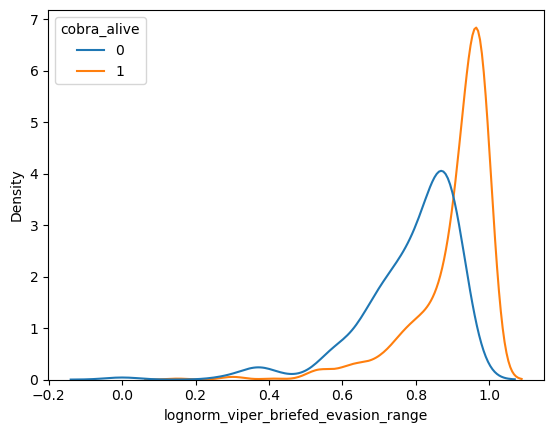

In [104]:
sns.kdeplot(x=df.lognorm_viper_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_cobra_briefed_evasion_range', ylabel='Density'>

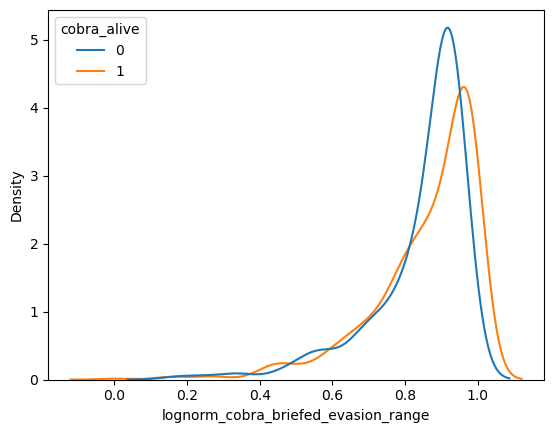

In [105]:
sns.kdeplot(x=df.lognorm_cobra_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

Setup train, test dataset

In [106]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

response1 = ["outcome"]
response2 = ["outcome"] + viper_portion_cols
response3 = ["outcome"] + viper_portion_cols + cobra_portion_cols

In [107]:
eps = 1e-4
df_copy = df.copy()
df_copy[viper_portion_cols] = df_copy[viper_portion_cols].replace(0, eps)
df_copy[viper_portion_cols] = df_copy[viper_portion_cols].replace(1, 1 - eps)
df_copy[viper_portion_cols] = normalize(df_copy[viper_portion_cols], norm="l1", axis=1)

df_copy[cobra_portion_cols] = df_copy[cobra_portion_cols].replace(0, eps)
df_copy[cobra_portion_cols] = df_copy[cobra_portion_cols].replace(1, 1 - eps)
df_copy[cobra_portion_cols] = normalize(df_copy[cobra_portion_cols], norm="l1", axis=1)

In [108]:
X = torch.tensor(df_copy[input_set5].values, dtype=torch.float)
# Need to torch.float for y, since we have categorical and proportions
y = torch.tensor(df_copy[response3].values, dtype=torch.float)

# redo this so the min, max values are in the training set for each dim
# manual_seed = 99

train_idx, test_idx = torch.utils.data.random_split(X, [.8, .2], \
    generator=torch.Generator().manual_seed(99))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
train_y = y[train_idx,:]
test_y = y[test_idx,:]

# if torch.cuda.is_available():
#     train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [277]:
input_dims = train_x.size(-1)
kernel_per_input = 6
active_dims = []

for i in range(input_dims):
    for j in range(1):
        for k in range(kernel_per_input):
            active_dims.append([i])

n_kernels = len(active_dims)
print("number of kernels =", n_kernels)

number of kernels = 24


# Fit the model

In [128]:
lengthscales = collections.defaultdict(list)
lmc_coeffs = collections.defaultdict(list)
neg_ELBO = collections.defaultdict(list)

In [458]:
scenarios = "(lmc_coeff_prior | lenthscale_prior)"
# code_values
# 0: no prior
# 1: weakly sparse inducing
# 2: sparse inducing
lmc_prior_code = 2
lengthscale_prior_code = 1
scenario_code = f"{lmc_prior_code}{lengthscale_prior_code}"
print("scenario_code:", scenario_code)

scenario_code: 21


In [459]:
if lmc_prior_code == 0:
        # lmc_coefficients_prior = None
        low = torch.tensor(-10, dtype=torch.float, device=train_x.device)
        high = torch.tensor(10, dtype=torch.float, device=train_x.device)
        lmc_coefficients_prior = UniformPrior(low, high)
elif lmc_prior_code == 1:
        lmc_coefficients_prior = gpytorch.priors.NormalPrior(0,1)
elif lmc_prior_code == 2:
        # lmc_coefficients_prior = HorseshoePrior(2.)
        # lmc_coefficients_prior = HorseshoePrior(1.)
        lmc_coefficients_prior = HorseshoePrior(.5)

if lengthscale_prior_code == 0:
        lengthscale_prior = None
elif lengthscale_prior_code == 1:
        gamma_mean = 1.
        gamma_std = 2.
        alpha = gamma_mean**2 / np.sqrt(gamma_std)
        beta = gamma_mean / np.sqrt(gamma_std)
        lengthscale_prior = GammaPrior(alpha, beta)        

batch_shape=torch.Size([1])
kernels = [
        [ProductKernel(
                RBFKernel(lengthscale_prior=lengthscale_prior, 
                          batch_shape=batch_shape), 
                LinearKernel(lengthscale_prior=lengthscale_prior, 
                             batch_shape=batch_shape)),
         MaternKernel(nu=3/2, 
                      lengthscale_prior=lengthscale_prior, 
                      batch_shape=batch_shape)] 
        for _ in range(12)]

kernels = list(itertools.chain(*kernels))

likelihoods = [dist.Categorical, dist.Dirichlet, dist.Dirichlet]

model = HetMOGP(train_x, num_lpf=11, likelihoods=likelihoods, kernels=kernels, active_dims=active_dims, num_inducing=100, jitter_val = 1e-3, n_compositions=[4, 4], 
                lmc_coefficients_prior=lmc_coefficients_prior
                )

# if torch.cuda.is_available():
#     model = model.cuda()

In [460]:
pyro.clear_param_store()

# num_iter = 2000
# num_iter = 1000 # for actual training
num_iter = 500 # for testing if the code works
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 or lower (for fast training, try final_lr = 1e-2)
# - decreasing num_iter
# - tightening the lengthscale prior or kernel parameters

initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})
    
elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
alpha = np.zeros((num_iter, 2))
beta = np.zeros((num_iter, 2))

for i in iterator:
    model.zero_grad()
    loss = svi.step(x=train_x, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)
    # store alpha, beta iters
    alpha[i] = np.array(pyro.get_param_store()["alpha"].detach().cpu())
    beta[i] = np.array(pyro.get_param_store()["beta"].detach().cpu())
    neg_ELBO[scenario_code].append(loss)

# computing time = 2:22 for y_0, y_1, loss = -99.5 / dim=-1 GPU
# computing time = 1:27 for y_0, y_1, loss = -101 / dim=-1 CPU

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

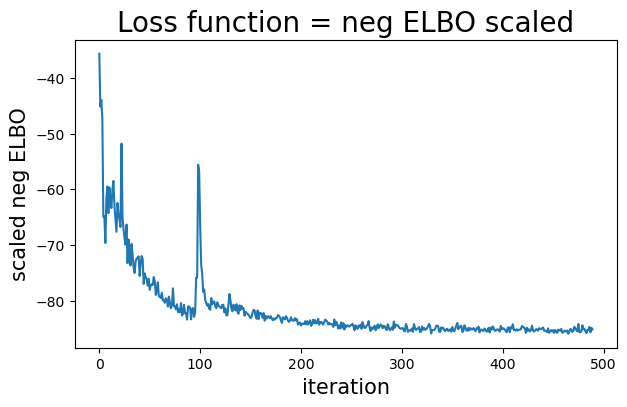

In [461]:
fig, ax = plt.subplots(figsize=(7,4))
loss_start = 10
ax.plot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])
ax.set_xlabel(r"iteration", fontdict={'fontsize':15})
ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':15})
ax.set_title(r"Loss function = neg ELBO scaled", fontsize=20);

In [462]:
kernel_parameters = collections.defaultdict(dict)

for i, module in enumerate(model.covar_module.kernel_modules):
    # Should always be True since we are using ScaleKernels
    k_parent = f"Kernel.{i}"
    if isinstance(module, ScaleKernel):
        kernel = module.base_kernel
    else:
        kernel = module
    if isinstance(kernel, (ProductKernel, AdditiveKernel)):
        # Sub kernels within ProductKernel / AdditiveKernel
        for j, ksub in enumerate(kernel.kernels):
            op_kernel_str = kernel._get_name()
            k_name = f"{op_kernel_str}.{j}.{ksub._get_name()}"
            kernel_parameters[k_parent][k_name] = collections.defaultdict(dict)
            for name, raw_value, constraint in ksub.named_parameters_and_constraints():
                param = name.split("_")[-1]
                value = constraint.transform(raw_value).detach().cpu().item()
                value = round(value, 4)
                kernel_parameters[k_parent][k_name][param] = value
    else:
        k_name = f"{kernel._get_name()}"
        kernel_parameters[k_parent][k_name] = collections.defaultdict(dict)
        for name, raw_value, constraint in kernel.named_parameters_and_constraints():
                param = name.split("_")[-1]
                value = constraint.transform(raw_value).detach().cpu().item()
                value = round(value, 4)                    
                kernel_parameters[k_parent][k_name][param] = value
    for name, raw_value, constraint in module.named_parameters_and_constraints():
        if "outputscale" in name:
            param = name.split("_")[-1]
            value = constraint.transform(raw_value).detach().cpu().item()
            value = round(value, 4)                    
            kernel_parameters[k_parent][param] = value

for key, val in kernel_parameters.items():
    for inner_key, inner_val in val.items():
        if isinstance(inner_val, dict):
            if "lengthscale" in inner_val.keys():
                lengthscales[scenario_code].append(inner_val["lengthscale"])
        
lmc_coeffs[scenario_code] = model.variational_strategy.lmc_coefficients.detach().cpu().flatten()

In [463]:
# Sturge's formula for calculating n_bins
n_bins = int(np.ceil(np.log2(lmc_coeffs["21"].size(0))) + 1)
lmc_concat = np.concatenate([lmc_coeffs["21"].abs(), lmc_coeffs["01"].abs()])
bin_width = round(lmc_concat.max() / n_bins,2)
# bins = np.arange(0, lmc_concat.max()+.2, step=bin_width)
bins = np.linspace(0, lmc_concat.max()+.1, lmc_coeffs["21"].size(0))
count_01, _ = np.histogram(lmc_coeffs["01"].abs(), bins=bins)
count_21, _ = np.histogram(lmc_coeffs["21"].abs(), bins=bins)

In [386]:
# from statsmodels.distributions.empirical_distribution import ECDF

# ecdf = ECDF(lmc_coeffs["21"].abs())

<AxesSubplot: >

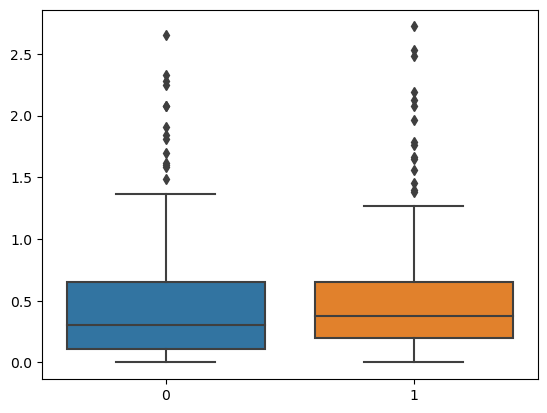

In [464]:
sns.boxplot(data=[np.array(lmc_coeffs["21"].abs()),
                  np.array(lmc_coeffs["01"].abs())])

<AxesSubplot: ylabel='Count'>

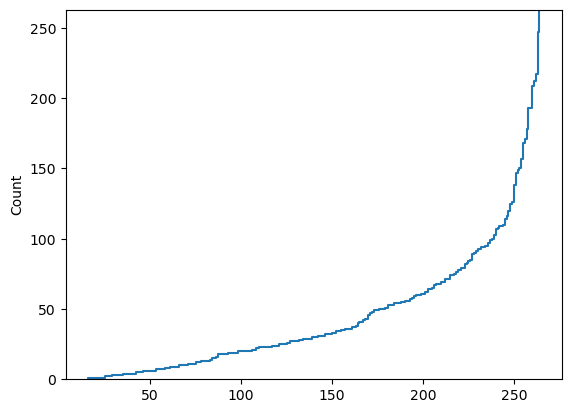

In [465]:
sns.ecdfplot(count_21.cumsum(), stat="count")

<AxesSubplot: ylabel='Count'>

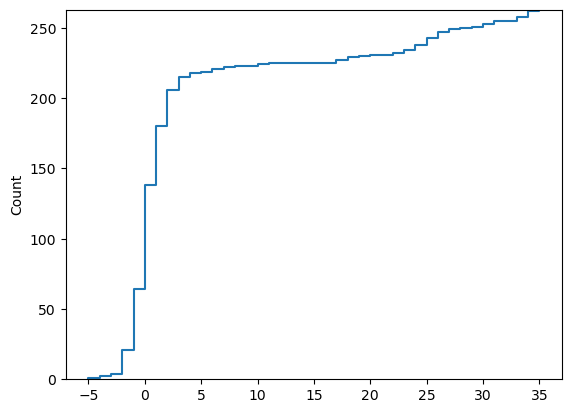

In [466]:
sns.ecdfplot(count_21.cumsum() - count_01.cumsum(), stat="count")

<AxesSubplot: ylabel='Count'>

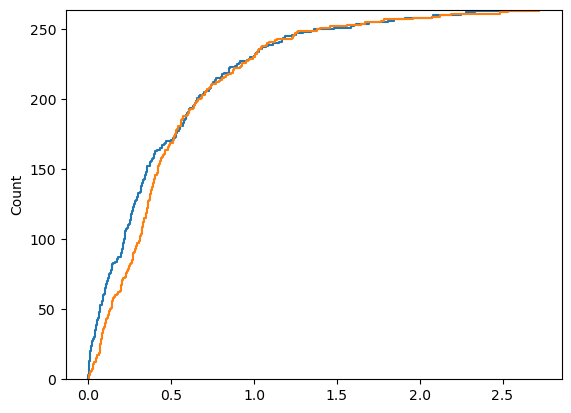

In [467]:
sns.ecdfplot(lmc_coeffs["21"].abs(), stat="count")
sns.ecdfplot(lmc_coeffs["01"].abs(), stat="count")

In [469]:
count_21.cumsum() - count_01.cumsum()

array([11, 18, 18, 23, 25, 28, 27, 25, 24, 24, 26, 26, 27, 25, 24, 26, 25,
       24, 23, 26, 33, 31, 30, 34, 33, 34, 33, 35, 34, 34, 30, 31, 29, 25,
       22, 20, 19, 17, 17, 10,  7,  8,  6,  6,  4,  2,  2,  0, -2, -3, -2,
       -2, -5, -4,  0,  1,  0,  1,  2, -1,  0,  1,  3,  1,  2,  0, -1, -1,
        1,  1,  1,  3,  3,  1,  3,  3,  3,  2,  3,  5,  4,  2,  2,  3,  4,
        3,  1,  1,  0,  0,  0,  1,  0,  0,  1,  1, -1, -1, -1, -1, -1, -2,
       -2, -1, -1, -2, -3, -2, -1,  1,  2,  2,  2,  2,  2,  0,  0, -2, -2,
       -2, -1, -1, -1, -1, -1,  0,  1,  1,  0,  0, -1, -1, -1, -1, -1, -2,
       -2, -2, -1, -1, -1, -1, -1, -1, -1, -2, -2, -1, -1,  0,  1,  1,  1,
        0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -2, -2, -1, -1,
       -1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0, -1,
       -1, -1, -1, -1, -1,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2

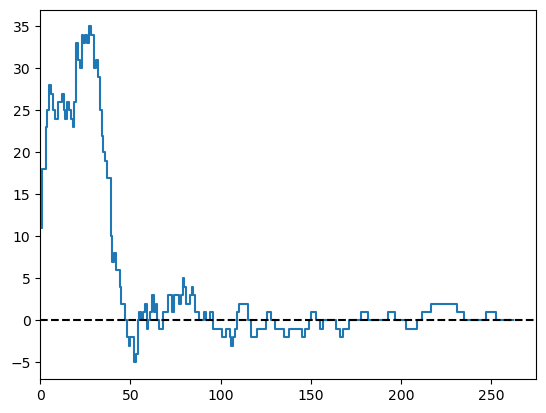

In [468]:
fig, ax = plt.subplots()

ax.step(x=np.arange(len(count_21)), y=count_21.cumsum() - count_01.cumsum(), where="post")
ax.set_xlim(0)
_, xmax = ax.get_xlim()
ax.hlines(0, 0, xmax, ls="--", colors="black")
# ax.set_xticks(np.arange(0, len(bins)))
# ax.set_xticklabels(bins)
# ax.set_xticks([0,1,2],rotate=90)

In [483]:
alpha[-1]**2 / beta[-1]

array([18.65791666, 19.46316097])

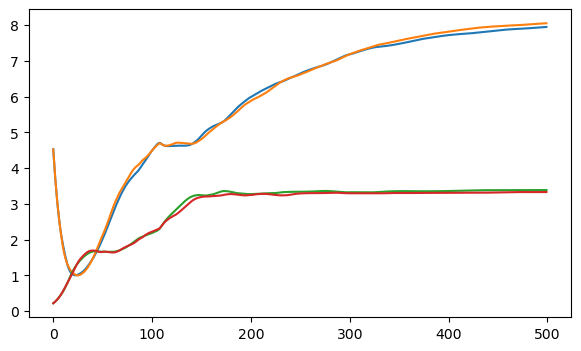

In [484]:
fig, ax = plt.subplots(figsize=(7,4))
loss_start = 0
ax.plot(np.arange(0, len(alpha) - loss_start), alpha[loss_start:])
ax.plot(np.arange(0, len(beta) - loss_start), beta[loss_start:])
# ax.set_xlabel(r"iteration", fontdict={'fontsize':15})
# ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':15})
# ax.set_title(r"Loss function = neg ELBO scaled", fontsize=20);

Explain reason for omitting signal variance for model

<AxesSubplot: ylabel='Density'>

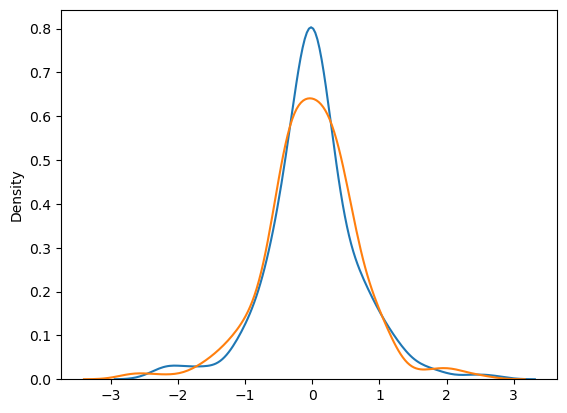

In [485]:
sns.kdeplot(lmc_coeffs["21"])
sns.kdeplot(lmc_coeffs["01"])

In [486]:
neg_ELBO["21"][-1], neg_ELBO["01"][-1]

(-85.180110107176, -85.9353109156713)

In [487]:
predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
predictions = predictive_dist(test_x, None, n_categories=3, n_compositions=[4, 4])
y0_pred = predictions["hmogp.y_0"].mode(0)[0].t().cpu()
y1_pred = predictions['hmogp.y_1'].median(0)[0].squeeze(0).cpu()
y2_pred = predictions['hmogp.y_2'].median(0)[0].squeeze(0).cpu()

In [488]:
predictions_train = predictive_dist(train_x, None, n_categories=3, n_compositions=[4, 4])
y0_pred_train = predictions_train["hmogp.y_0"].mode(0)[0].t().cpu()
y1_pred_train = predictions_train["hmogp.y_1"].median(0)[0].squeeze(0).cpu()
y2_pred_train = predictions_train["hmogp.y_2"].median(0)[0].squeeze(0).cpu()

Evaluating the model

In [489]:
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

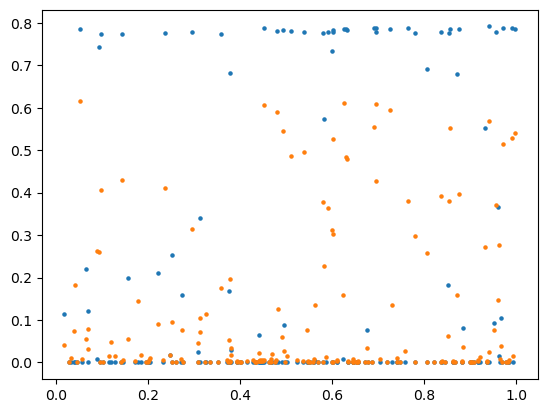

In [490]:
fig, ax = plt.subplots()

i = 2
p = 3
ax.scatter(test_x[...,i], test_y[...,p+1], s=5)
ax.scatter(test_x[...,i], y1_pred[...,p], s=5)

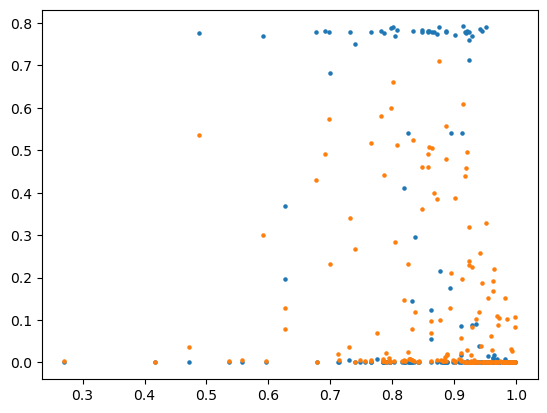

In [491]:
fig, ax = plt.subplots()

i = 3
p = 3
ax.scatter(test_x[...,i], test_y[...,p+5], s=5)
ax.scatter(test_x[...,i], y2_pred[...,p], s=5)

In [492]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [493]:
# # posterior predictive dist with outputs of size x.size()
# def ppd_given_input(model, x, n_samples=1000):
#     x_ = x
#     # if not x.is_cuda:
#         # x_ = x.cuda()
    
#     model.eval()
#     with torch.no_grad():
#         ppd = model(x_)

#     return ppd

# # obtain samples from ppd. get median or samples
# def sample_from_ppd(ppd, n_samples=1000, return_median=True):
#     samples = ppd.sample_n(n_samples)
#     if return_median: 
#         return samples.mode(0)[0]
#     else:
#         return samples

# lpf_ppd = ppd_given_input(
#     model=model,
#     x=test_x,
# )

# lpf_lower, lpf_upper = lpf_ppd.confidence_region()
# lpf_mean = lpf_ppd.mean
# lpf_lower, lpf_upper, lpf_mean = lpf_lower.cpu(), lpf_upper.cpu(), lpf_mean.cpu()

# lpf_ppd_train = ppd_given_input(
#     model=model,
#     x=train_x,
# )

# lpf_lower_train, lpf_upper_train = lpf_ppd_train.confidence_region()
# lpf_mean_train = lpf_ppd_train.mean
# lpf_lower_train, lpf_upper_train, lpf_mean_train = lpf_lower_train.cpu(), lpf_upper_train.cpu(), lpf_mean_train.cpu()

# # ppd of observations
# y1_ppd = dist.OrderedLogistic(lpf_mean, mu_cutpoints).to_event(1)
# y1_ppd_train = dist.OrderedLogistic(lpf_mean_train, mu_cutpoints).to_event(1)

In [494]:
# # Draw some simulated y values
# y_sim = torch.stack(
#     [sample_from_ppd(y1_ppd)],
#     dim=-1
# ).squeeze(-1)
# y_sim_train = torch.stack(
#     [sample_from_ppd(y1_ppd_train)],
#     dim=-1
# ).squeeze(-1)

In [495]:
def compute_nlpd(
    dist,
    y,
    sum_log_prob = True
):
    output_dim = len(dist)
    nlpd = dist[0].log_prob(y[...,0])
    if sum_log_prob:
        nlpd = nlpd.sum()
    for d in range(1,output_dim):
        nlpd0 = dist[d].log_prob(y[...,d])
        if sum_log_prob:
            nlpd0 = nlpd0.sum()
        nlpd = torch.stack([nlpd, nlpd0])
    return nlpd

In [496]:
# nlpd = compute_nlpd([y1_ppd], test_y)
# print("nlpd:", nlpd)

The misclassification rate for Mutual Kill reduces when adding y_1 and y_2 proportions into the model

In [497]:
list(outcome_map.keys())[::-1]

['COBRA_WIN', 'BOTH_SURVIVED', 'VIPER_WIN']

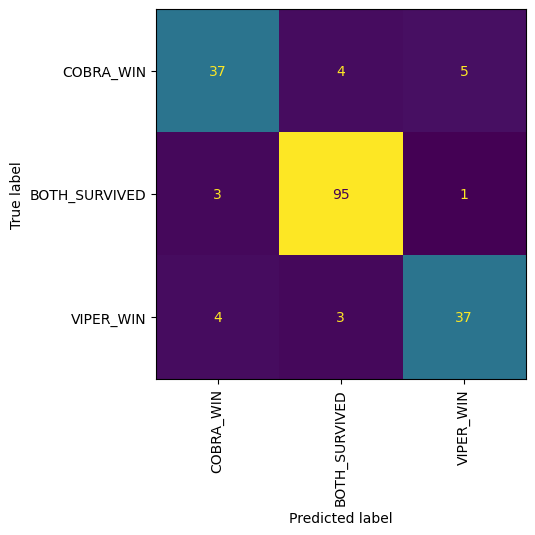

In [498]:
# outcome from using log_norm transformation
cm_test = confusion_matrix(test_y[...,0], y0_pred)
cm_display = ConfusionMatrixDisplay(cm_test, display_labels=list(outcome_map.keys())[::-1]).plot(colorbar=False)
plt.xticks(rotation=90);

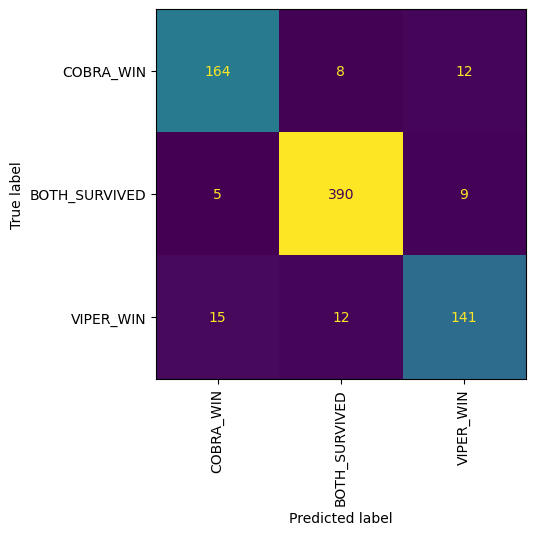

In [499]:
# outcome from using log_norm transformation
cm_train = confusion_matrix(train_y[...,0], y0_pred_train)
cm_display = ConfusionMatrixDisplay(cm_train, display_labels=list(outcome_map.keys())[::-1]).plot(colorbar=False)
plt.xticks(rotation=90);

Analyse (1) independent latent function, and (2) latent parameter functions

In [500]:
model.eval()

with torch.no_grad():
    ind_latent_fn = model.variational_strategy.ind_latent_fn
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu().detach()

ilf_lower, ilf_upper = ind_latent_fn.confidence_region()
ilf_mean = ind_latent_fn.mean
# ilf_lower, ilf_upper, ilf_mean = ilf_lower.cpu(), ilf_upper.cpu(), ilf_mean.cpu()
ilf_lower, ilf_upper, ilf_mean = ilf_lower.detach().cpu(), ilf_upper.detach().cpu(), ilf_mean.detach().cpu()

In [501]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [502]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [503]:
outcome_l = [
    'Red Win',
    # 'RedBlue Killed',
    'RedBlue Survived',
    'Blue Win', 
    'Blue Neutral',
    'Blue Defense',
    'Blue Headon', 
    'Blue Offense',
    'Red Neutral', 
    'Red Defense', 
    'Red Headon', 
    'Red Offense'
]

c_map = {
    'Red Win': "red",
    # 'RedBlue Killed': "orange",
    'RedBlue Survived': "grey",
    'Blue Win': "blue", 
    'Blue Neutral': "blue",
    'Blue Defense': "blue",
    'Blue Headon': "blue", 
    'Blue Offense': "blue",
    'Red Neutral': "red", 
    'Red Defense': "red", 
    'Red Headon': "red", 
    'Red Offense': "red",
}

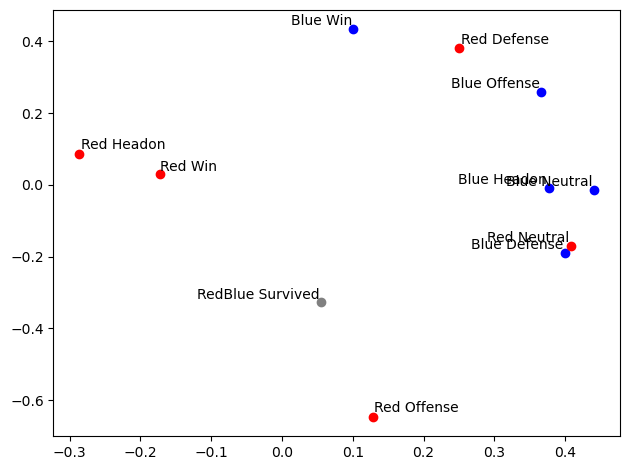

In [504]:
eigval, eigvec = eigen(lmc_coefficients, norm=True)
fig, ax = plt.subplots()
for i in range(len(outcome_l)):
    x = eigvec[i,0]
    y = eigvec[i,1]
    ax.scatter(x=x, y=y, c=c_map[outcome_l[i]])
    text = [ax.text(x, y, outcome_l[i])]
    adjust_text(text)
fig.tight_layout()
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1);

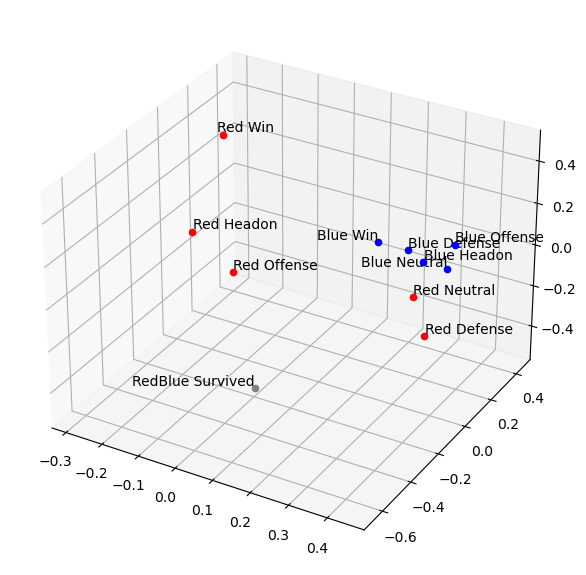

In [505]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

for i in range(len(outcome_l)):
    x = eigvec[i,0]
    y = eigvec[i,1]
    z = eigvec[i,2]
    ax.scatter3D(x, y, z, c=c_map[outcome_l[i]])
    # ax.text(x, y, z, outcome_l[i])
    text = [ax.text(x, y, z, outcome_l[i])]
    adjust_text(text)
    
fig.tight_layout()

HD: Including variance explained for each PCA component

<AxesSubplot: >

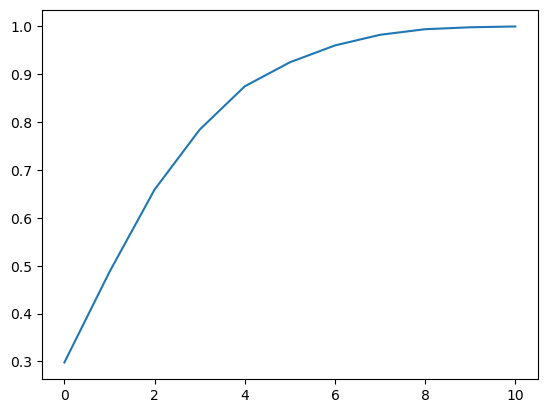

In [506]:
r_squared = np.cumsum(eigval / eigval.sum())
sns.lineplot(x=np.arange(len(eigval)), y=r_squared)

<AxesSubplot: >

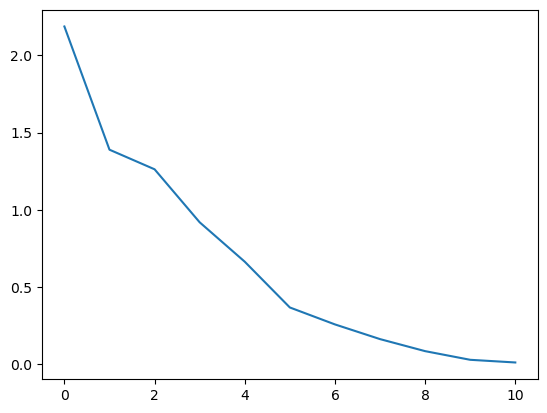

In [507]:
sns.lineplot(x=np.arange(len(eigval)), y=eigval)

In [508]:
inputs = [
    'viper_launch_range',
    'viper_briefed_evasion_range',
    'cobra_launch_range',
    'cobra_briefed_evasion_range',
]

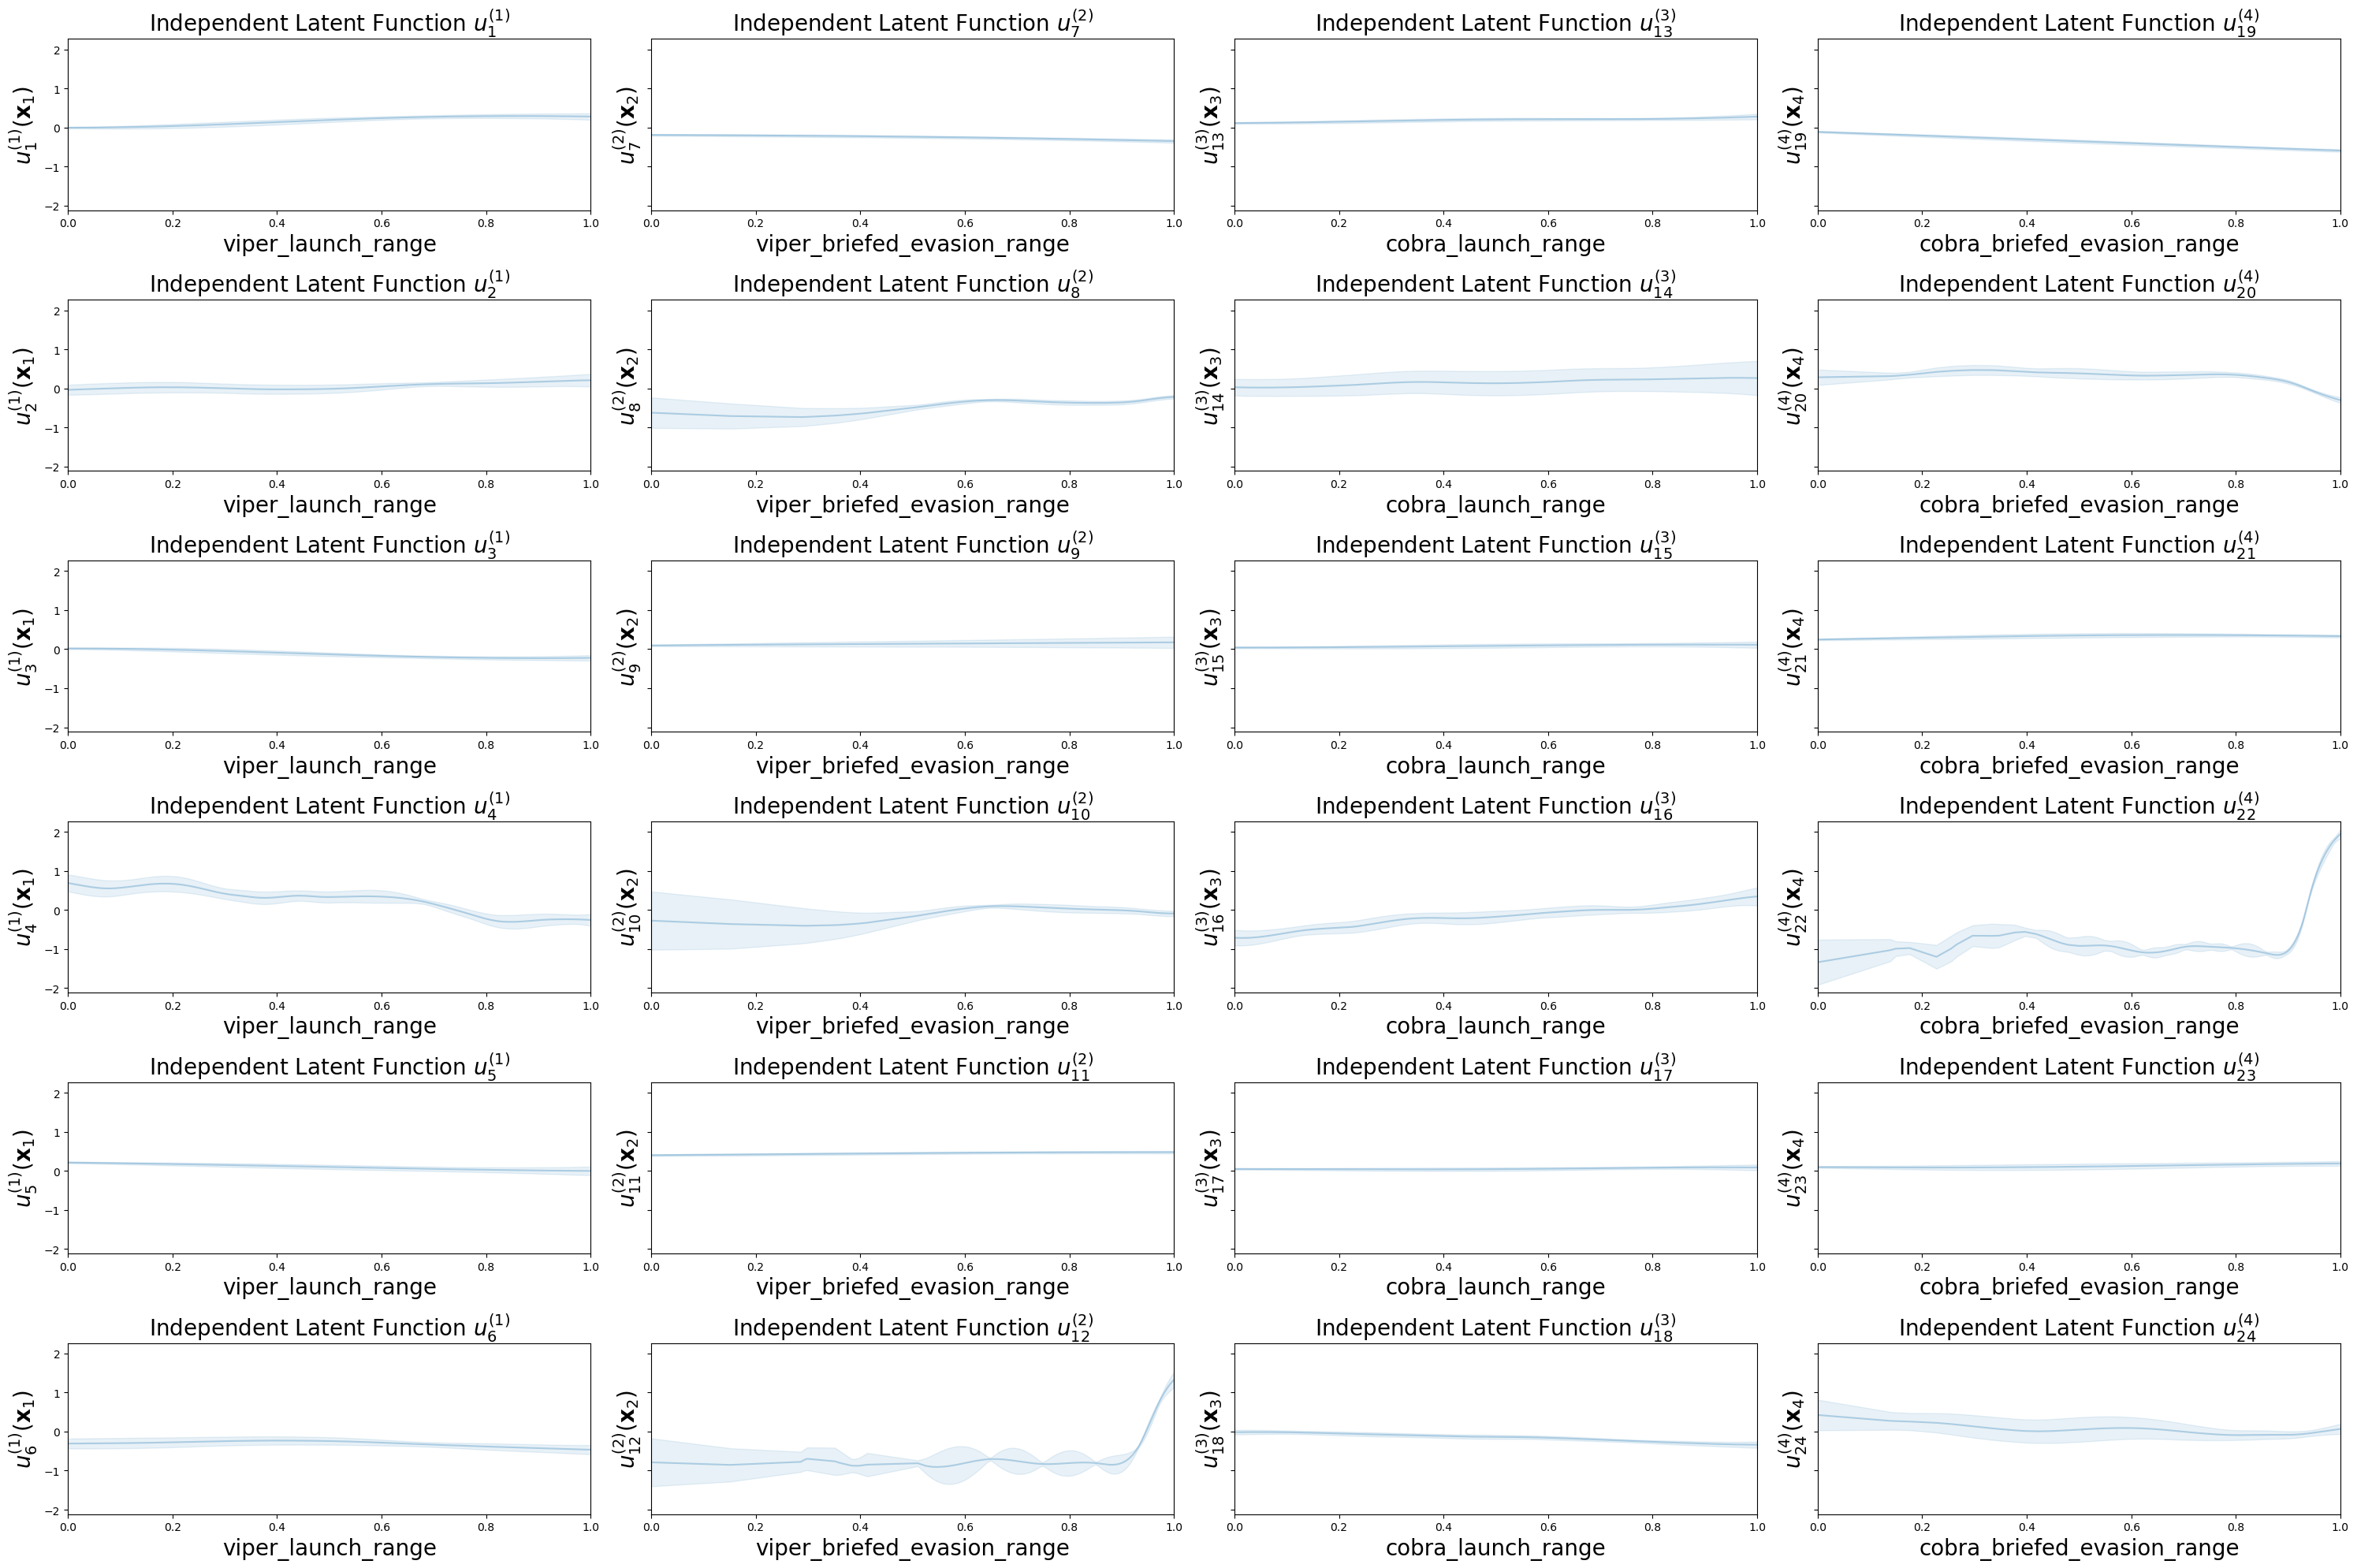

In [509]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 3

# visualize the result
fig, func = plt.subplots(nrows=num_latents // input_dim, ncols=input_dim, figsize=(30, 20), sharey=True)
# x="x"

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            line, = func[row,j].plot(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
            func[row,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.1, color=line.get_color()
            )
            # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            func[row,j].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row,j].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlim([0.,1.])
            row += 1

fig.tight_layout()

In [510]:
def compute_f_pd_p(x, input_dim, output_d, ilf, lmc, active_dims, get_indices=True):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,output_d]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

plot (viper_launch_range, Red Win) in row=0, col=0
plot (viper_launch_range, RedBlue Survived) in row=1, col=0
plot (viper_launch_range, Blue Win) in row=2, col=0
plot (viper_briefed_evasion_range, Red Win) in row=0, col=1
plot (viper_briefed_evasion_range, RedBlue Survived) in row=1, col=1
plot (viper_briefed_evasion_range, Blue Win) in row=2, col=1
plot (cobra_launch_range, Red Win) in row=0, col=2
plot (cobra_launch_range, RedBlue Survived) in row=1, col=2
plot (cobra_launch_range, Blue Win) in row=2, col=2
plot (cobra_briefed_evasion_range, Red Win) in row=0, col=3
plot (cobra_briefed_evasion_range, RedBlue Survived) in row=1, col=3
plot (cobra_briefed_evasion_range, Blue Win) in row=2, col=3


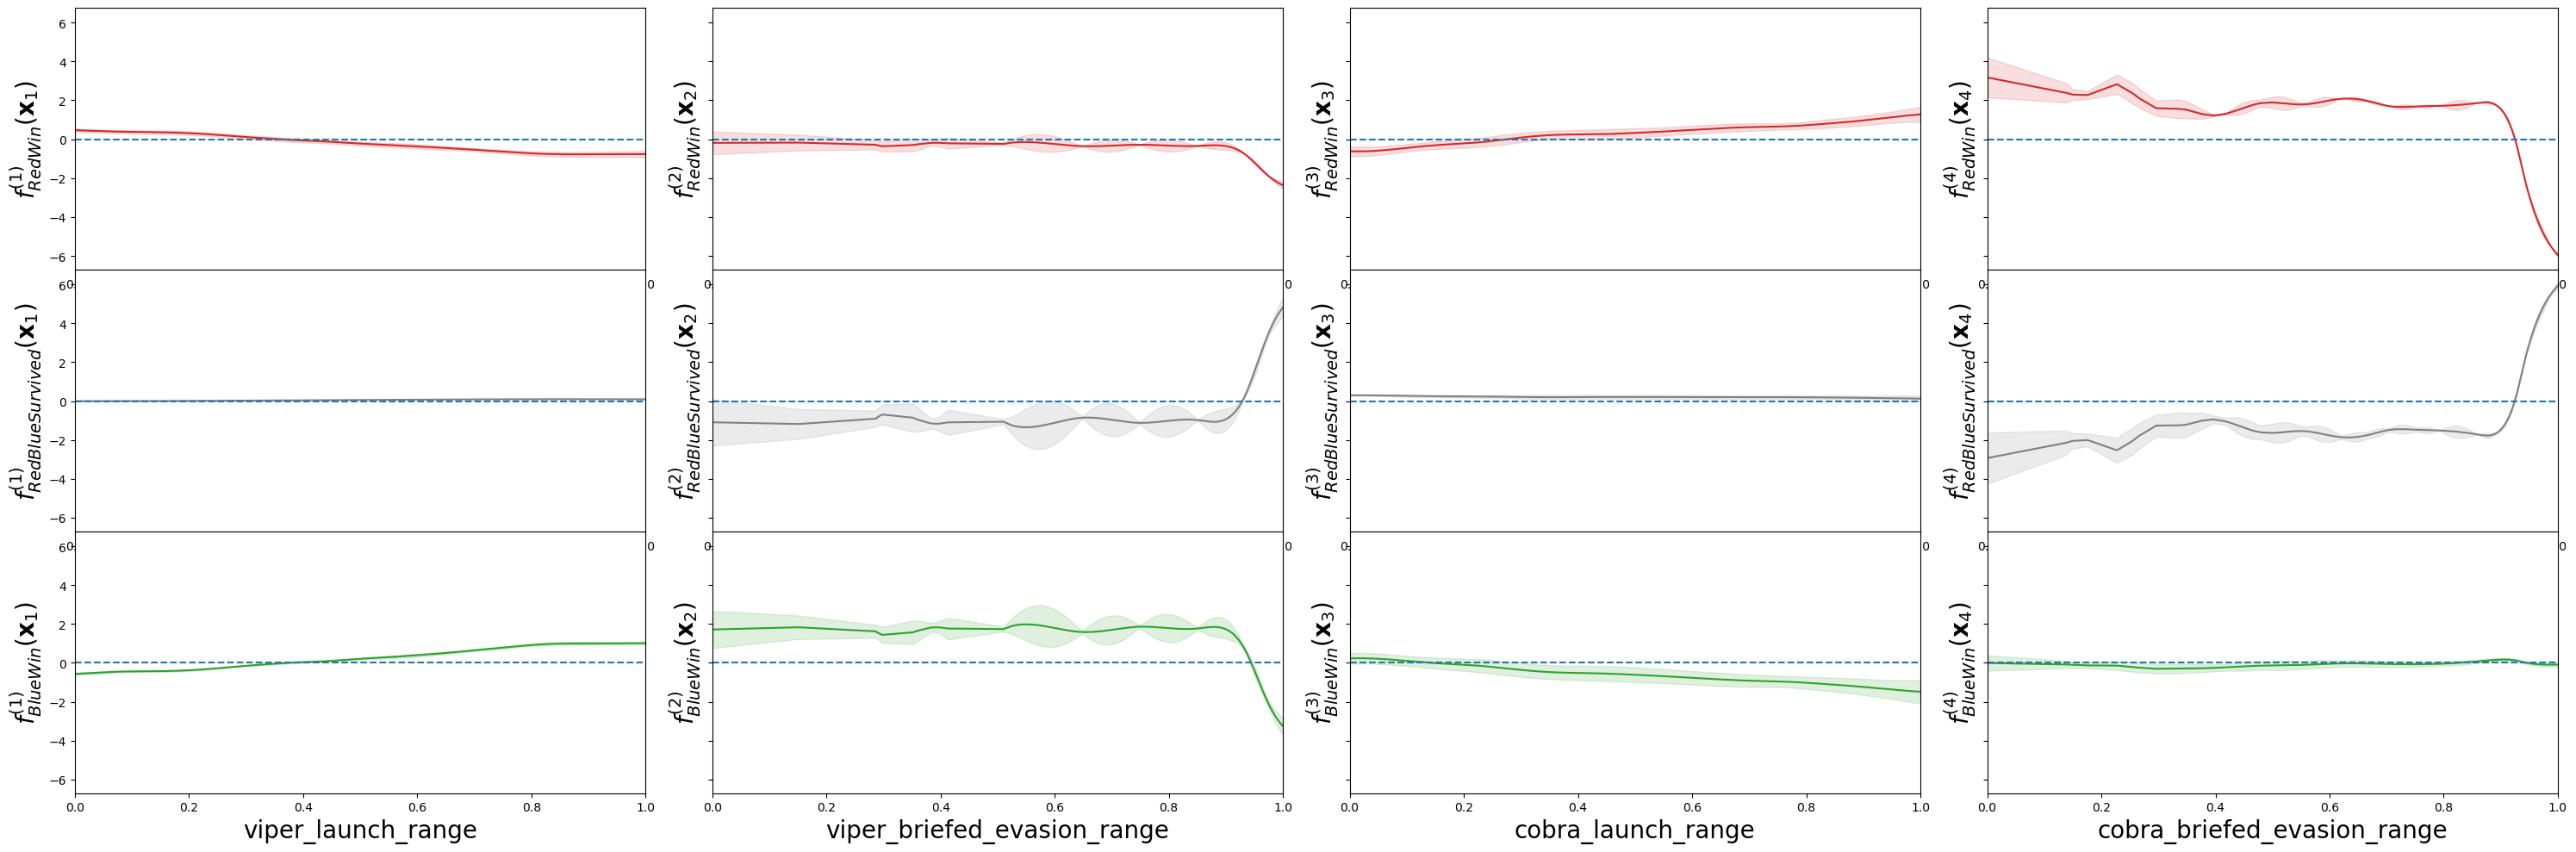

In [511]:
# visualize the result
categories = outcome_l[:4]
input_dim = train_x.size(-1)
n_categories = 3

# visualize the result
fig, func = plt.subplots(nrows=n_categories, ncols=input_dim, figsize=(30, 10), sharey=True)
# c = ["tab:red", "tab:orange", "tab:gray", "tab:green"]
c = ["tab:red", "tab:gray", "tab:green"]

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        print(f"plot ({inputs[j]}, {categories[row]}) in row={row}, col={j}")
        indices = np.argsort(train_x[:,j]) 
        indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
        line, = func[row,j].plot(train_x[indices,j], f_mean, alpha=0.99, c=c[row])
        func[row,j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.15, color=line.get_color()
        )
        func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
        func[row,j].set_ylabel(f"${{f_{{{categories[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[row,j].set_xlim([0.,1.])
        func[row,j].hlines(0, 0, 1, ls="--")
        row += 1

fig.tight_layout()
fig.subplots_adjust(hspace=0)

In [512]:
score = scotts_pi(cm_test, weight_type="unweighted")
print("scotts_pi:", score)

scotts_pi: 0.8258


In [513]:
c_map = {
    "cobra_launch_range": "maroon",
    "cobra_briefed_evasion_range": "indianred",
    "viper_launch_range": "navy",
    "viper_briefed_evasion_range": "royalblue",
}

ls_map = {
    'viper_launch_range': "-",
    'viper_briefed_evasion_range': "-.",
    'cobra_launch_range': "-",
    'cobra_briefed_evasion_range': "-.",
}

alpha_map = {
    'viper_launch_range': .9,
    'viper_briefed_evasion_range': .9,
    'cobra_launch_range': .9,
    'cobra_briefed_evasion_range': .9,
}

Text(0.0, -20.5, 'scotts_pi score: 0.8258')

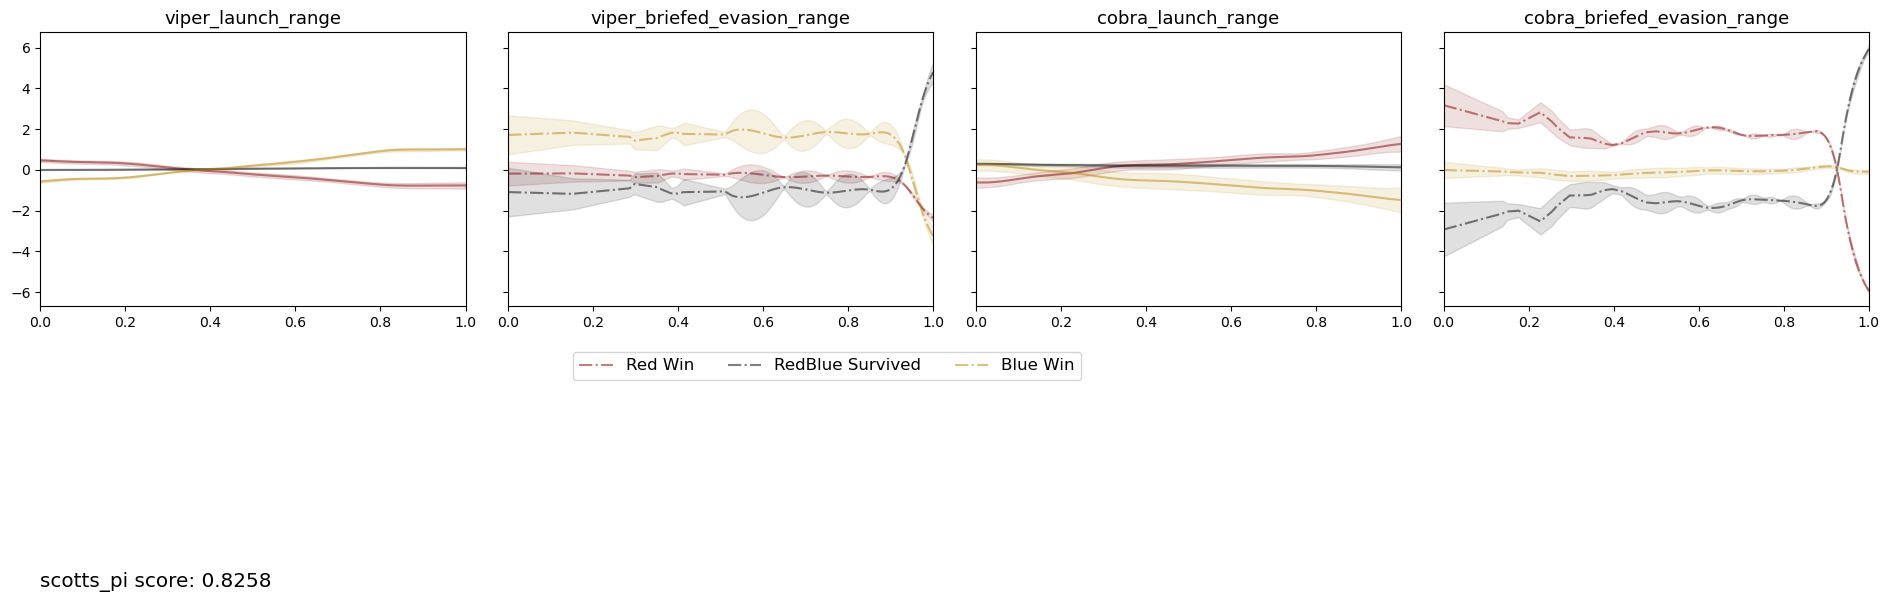

In [514]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)

# visualize the result
fig, func = plt.subplots(ncols=input_dim, figsize=(19, 3.5), sharey=True)
# x="x"

c = ["maroon", "black", "darkgoldenrod", "navy"]

ilf_idx = 0
for j in range(input_dim):
    for i in range(n_categories):
        c_ = c[i]
        ls = ls_map[inputs[j]]
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, i, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, i, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, i, ilf_upper, lmc_coefficients, active_dims)
        line, = func[j].plot(train_x[indices,j], f_mean, alpha=0.5, label=categories[i], c=c_, ls=ls)
        func[j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[j].set_xlabel(inputs[j], fontdict={'fontsize':10})
        # func[j].set_ylabel(f"${{f_{{{outcome_l[i]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[j].set_title(inputs[j], fontdict={'fontsize':13})
        func[j].set_xlim([0.,1.])
        # func[j].hlines(0, 0, 1, ls="--")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(.75, -.3), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -20.5), fontsize="x-large", annotation_clip=False)

Text(0.0, -20.5, 'scotts_pi score: 0.8258')

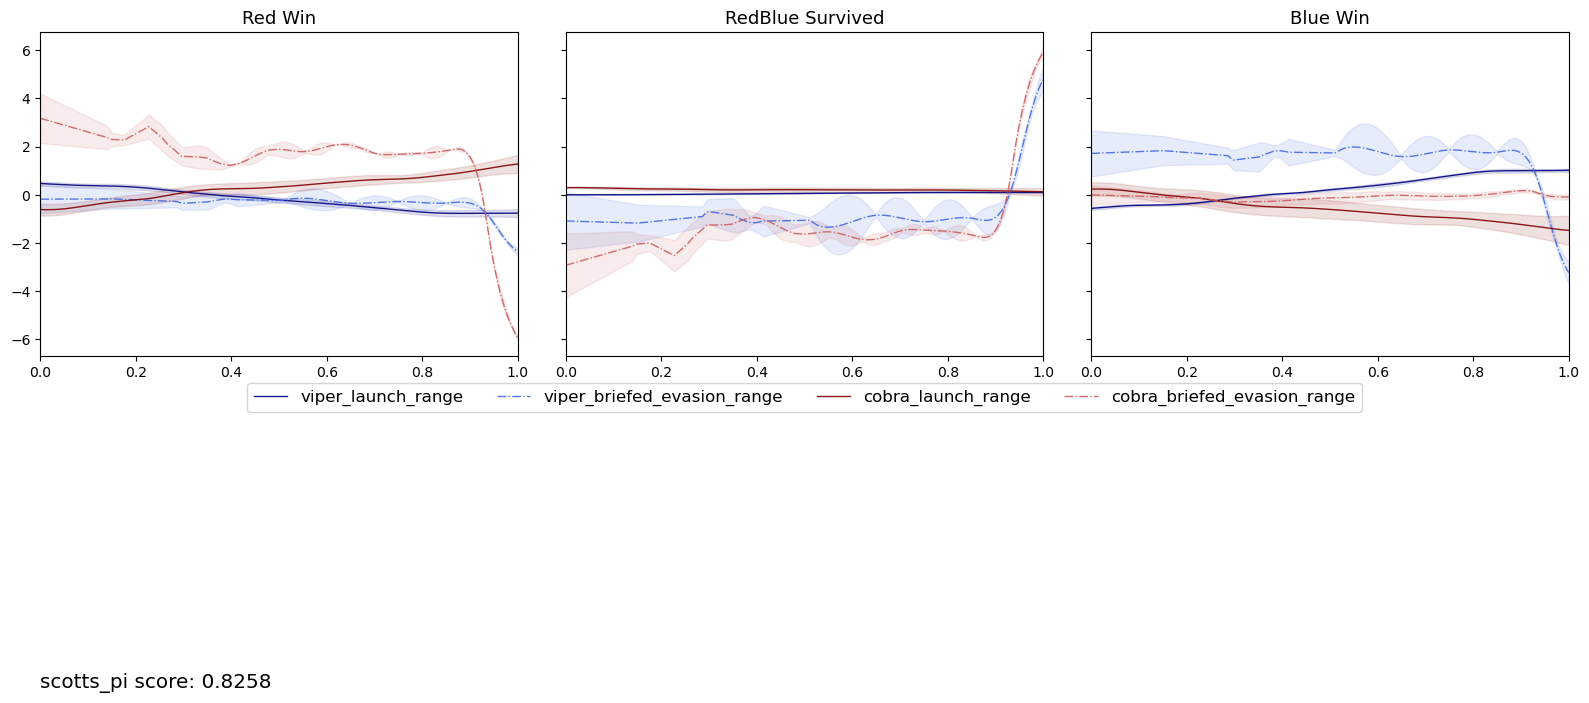

In [515]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 3

# visualize the result
fig, func = plt.subplots(nrows=1, ncols=n_categories, figsize=(16, 4), sharey=True)

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        c = c_map[inputs[j]]
        ls = ls_map[inputs[j]]
        alpha = alpha_map[inputs[j]]
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
        line, = func[row].plot(train_x[indices,j], f_mean, alpha=alpha, lw=1, label=inputs[j], c=c, ls=ls)
        func[row].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[row].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[row].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[row].set_title(categories[row], fontdict={'fontsize':13})
        # func[row].hlines(0, 0, 1, ls="-", color="k", lw=.5)
        func[row].set_xlim([0.,1.])
        # func[row].legend()
        row += 1

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(.5, -.2), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -20.5), fontsize="x-large", annotation_clip=False)